In [1]:
from Lib.myModules.my_ML_Modules_1 import *
import math
import sys
import contextlib

In [2]:
# Read all data
data_dir = "../data"
infantNum = 9
ECG_dataset = f"{data_dir}/infant{infantNum}_ecg"
RESP_dataset = f"{data_dir}/infant{infantNum}_resp"

signal_ecg_0 = wfdb.rdsamp(f"{data_dir}/infant{infantNum}_ecg")
signal_resp_0 = wfdb.rdsamp(f"{data_dir}/infant{infantNum}_resp")
print(f'ECG DATA: {signal_ecg_0[1]}')
print(F'RESP DATA: {signal_resp_0[1]}')
totalDuration_ECG = num2Time(num=signal_ecg_0[1]['sig_len'], fs=signal_ecg_0[1]['fs'])
print(f'{totalDuration_ECG} sec, {secs2minutes(totalDuration_ECG)} minutes, {secs2hours(totalDuration_ECG)} hours')
totalDuration_RESP = num2Time(num=signal_resp_0[1]['sig_len'], fs=signal_resp_0[1]['fs'])
print(f'{totalDuration_RESP} sec, {secs2minutes(totalDuration_RESP)} minutes, {secs2hours(totalDuration_RESP)} hours')

ECG DATA: {'fs': 500, 'sig_len': 78684614, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['II'], 'comments': []}
RESP DATA: {'fs': 50, 'sig_len': 7868296, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['NU'], 'sig_name': ['RESP'], 'comments': []}
157369.228 sec, 2622.8204666666666 minutes, 43.71367444444444 hours
157365.92 sec, 2622.7653333333337 minutes, 43.71275555555556 hours


In [3]:
start_time_secs = hours2secs(2)
end_time_secs = hours2secs(6)

In [4]:
def data_bin(start_time_secs, end_time_secs, signal_ecg_0, signal_resp_0, ECG_dataset, RESP_dataset):
    ECG_startNum = time2Num(start_time_secs, signal_ecg_0[1]['fs'])
    ECG_endNum = time2Num(end_time_secs, signal_ecg_0[1]['fs'])
    print(f'start: {ECG_startNum}, end: {ECG_endNum}')
    RESP_startNum = time2Num(start_time_secs, signal_resp_0[1]['fs'])
    RESP_endNum = time2Num(end_time_secs, signal_resp_0[1]['fs'])
    print(f'start: {RESP_startNum}, end: {RESP_endNum}')
    signal_ECG, signal_ECG_startTime_secs, signal_ECG_endTime_secs = read_Data(ECG_dataset, startNum=ECG_startNum, endNum=ECG_endNum)
    signal_RESP, signal_RESP_startTime_secs, signal_RESP_endTime_secs = read_Data(RESP_dataset, startNum=RESP_startNum, endNum=RESP_endNum)
    # print(signal_ECG[0].shape)
    signal_ECG_1 = iqr_smooth(signal=signal_ECG[0],hiPerc=90,loPerc=10, cutoff_factor=1)
    # print(signal_RESP[0].shape)
    signal_RESP_1 = iqr_smooth(signal=signal_RESP[0],hiPerc=90,loPerc=10, cutoff_factor=1)
    signal_ECG_2 = norm_signal(signal=signal_ECG_1)
    signal_RESP_2 = norm_signal(signal=signal_RESP_1)
    hrs_0 = cal_heartrate(signal=signal_ECG_2, fs=signal_ECG[1]['fs'])
    rrs_0 = cal_resprate(signal=signal_RESP_2, fs=signal_RESP[1]['fs'])
    if (rrs_0.shape[0] < hrs_0.shape[0]):
        hrs_1 = data_resample(data_fixNan(hrs_0), rrs_0.shape[0])
        rrs_1 = data_fixNan(rrs_0)
    else:
        rrs_1 = data_resample(data_fixNan(rrs_0), hrs_0.shape[0])
        hrs_1 = data_fixNan(hrs_0)
    return rrs_1, hrs_1

In [5]:
def test_lr_model(model, X, y, **kwargs):
    X = X.reshape((-1,1))
    y = y.reshape((-1,1))

    y_predict = model.predict(X)
    mae = mean_absolute_error(y, y_predict)
    mse = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    return y_predict

In [6]:
X, y = data_bin(start_time_secs=start_time_secs, 
                end_time_secs=end_time_secs, 
                signal_ecg_0=signal_ecg_0,
                signal_resp_0=signal_resp_0,
                ECG_dataset=ECG_dataset,
                RESP_dataset=RESP_dataset)

start: 3600000, end: 10800000
start: 360000, end: 1080000
90th percentile: 0.13324036895660696, 10th percentile: -0.14112960132903762, IQR: 0.2743699702856446
Identified outliers: 467139
Data Shape: (7200000,)
90th percentile: 23.209182714432263, 10th percentile: 20.66427639050757, IQR: 2.5449063239246925
Identified outliers: 63184
Data Shape: (720000,)


In [7]:
filename = '../models/infant_2/lr_model_step0.25_startHrs10_endHrs12.sav'
load_lr_models = joblib.load(filename)
y_predict_2 = test_lr_model(model=load_lr_models, X=X, y=y)
print(y_predict_2)

Mean absolute error: 11.32
Mean squared error: 342.81
Root mean squared error: 18.52
[[125.85673]
 [125.85673]
 [125.85673]
 ...
 [128.6383 ]
 [128.6383 ]
 [128.6383 ]]


In [8]:
filename = '../models/infant_3/lr_model_step0.25_startHrs10_endHrs12.sav'
load_lr_models = joblib.load(filename)
y_predict_3 = test_lr_model(model=load_lr_models, X=X, y=y)
print(y_predict_3)

Mean absolute error: 11.62
Mean squared error: 347.49
Root mean squared error: 18.64
[[129.28072]
 [129.28072]
 [129.28072]
 ...
 [129.46861]
 [129.46861]
 [129.46861]]


In [9]:
print(y_predict_2)
print(y_predict_3)

[[125.85673]
 [125.85673]
 [125.85673]
 ...
 [128.6383 ]
 [128.6383 ]
 [128.6383 ]]
[[129.28072]
 [129.28072]
 [129.28072]
 ...
 [129.46861]
 [129.46861]
 [129.46861]]


In [10]:
# y_predict = (y_predict_2+y_predict_3)/2
# print(y_predict)

In [11]:
step = 0.25
startHrs = 10
endHrs = 12

filename = f"../models/infant_1/lr_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
print(filename)
load_lr_models = joblib.load(filename)
y_predict = test_lr_model(model=load_lr_models, X=X, y=y)

for infantNum in range(2, 9, 1):
    filename = f"../models/infant_{infantNum}/lr_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
    print(filename)
    load_lr_models = joblib.load(filename)
    y_predict_temp = test_lr_model(model=load_lr_models, X=X, y=y)
    y_predict += y_predict_temp

y_predict = y_predict/8
print("-------------------------------------------------------------------------------------------")
mae = mean_absolute_error(y, y_predict)
mse = mean_squared_error(y, y_predict)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

../models/infant_1/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 27.48
Mean squared error: 905.51
Root mean squared error: 30.09
../models/infant_2/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.32
Mean squared error: 342.81
Root mean squared error: 18.52
../models/infant_3/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.62
Mean squared error: 347.49
Root mean squared error: 18.64
../models/infant_4/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 40.09
Mean squared error: 1868.87
Root mean squared error: 43.23
../models/infant_5/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 32.95
Mean squared error: 1275.60
Root mean squared error: 35.72
../models/infant_6/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 13.54
Mean squared error: 367.42
Root mean squared error: 19.17
../models/infant_7/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 33.35
Mean squared error: 1287.11
Root m

In [12]:
print(y_predict)


[[144.2206 ]
 [144.2206 ]
 [144.2206 ]
 ...
 [145.01698]
 [145.01698]
 [145.01698]]


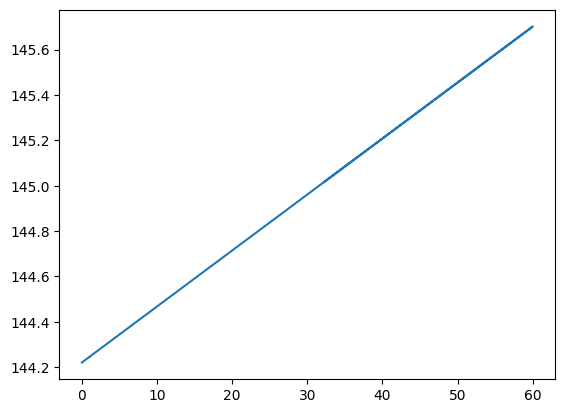

In [13]:
plt.plot(X, y_predict)
# plt.ylim(110,150)

In [14]:
def average_lr_model_predict(X, y):
    step = 0.25
    startHrs = 10
    endHrs = 12

    filename = f"../models/infant_1/lr_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
    print(filename)
    load_lr_models = joblib.load(filename)
    y_predict = test_lr_model(model=load_lr_models, X=X, y=y)

    for infantNum in range(2, 9, 1):
        filename = f"../models/infant_{infantNum}/lr_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
        print(filename)
        load_lr_models = joblib.load(filename)
        y_predict_temp = test_lr_model(model=load_lr_models, X=X, y=y)
        y_predict += y_predict_temp

    y_predict = y_predict/8
    print("-------------------------------------------------------------------------------------------")
    mae = mean_absolute_error(y, y_predict)
    mse = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    return y_predict

In [15]:
y_lr_predict = average_lr_model_predict(X=X,y=y)

../models/infant_1/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 27.48
Mean squared error: 905.51
Root mean squared error: 30.09
../models/infant_2/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.32
Mean squared error: 342.81
Root mean squared error: 18.52
../models/infant_3/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.62
Mean squared error: 347.49
Root mean squared error: 18.64
../models/infant_4/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 40.09
Mean squared error: 1868.87
Root mean squared error: 43.23
../models/infant_5/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 32.95
Mean squared error: 1275.60
Root mean squared error: 35.72
../models/infant_6/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 13.54
Mean squared error: 367.42
Root mean squared error: 19.17
../models/infant_7/lr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 33.35
Mean squared error: 1287.11
Root m

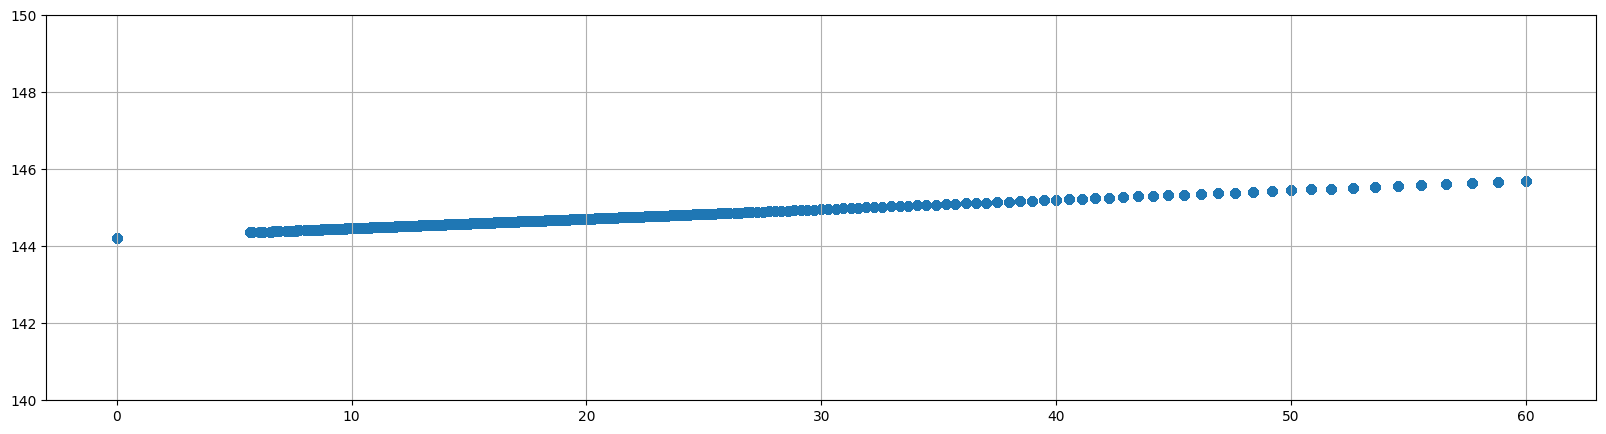

In [16]:
plt.figure(num=1, figsize=(20,5))
plt.scatter(X, y_lr_predict)
plt.ylim(140,150)
plt.grid(True)

In [17]:
def test_pr_model(model, X, y, degree=2, **kwargs):
    X = X.reshape((-1,1))
    y = y.reshape((-1,1))

    transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = transformer.fit_transform(X)
    y_predict = model.predict(X_poly)
    mae = mean_absolute_error(y, y_predict)
    mse = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    return y_predict

In [18]:
def average_pr_model_predict(X, y):
    step = 0.25
    startHrs = 10
    endHrs = 12
    degree = 6

    filename = f"../models/infant_1/pr_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
    print(filename)
    load_pr_models = joblib.load(filename)
    y_predict = test_pr_model(model=load_pr_models, X=X, y=y, degree=degree)

    for infantNum in range(2, 9, 1):
        filename = f"../models/infant_{infantNum}/pr_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
        print(filename)
        load_pr_models = joblib.load(filename)
        y_predict_temp = test_pr_model(model=load_pr_models, X=X, y=y, degree=degree)
        y_predict += y_predict_temp

    y_predict = y_predict/8
    print("-------------------------------------------------------------------------------------------")
    mae = mean_absolute_error(y, y_predict)
    mse = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    return y_predict

In [19]:
y_pr_predict = average_pr_model_predict(X=X,y=y)

../models/infant_1/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 27.57
Mean squared error: 911.64
Root mean squared error: 30.19
../models/infant_2/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.18
Mean squared error: 333.18
Root mean squared error: 18.25
../models/infant_3/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.43
Mean squared error: 328.61
Root mean squared error: 18.13
../models/infant_4/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 40.08
Mean squared error: 1867.62
Root mean squared error: 43.22
../models/infant_5/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 32.53
Mean squared error: 1248.74
Root mean squared error: 35.34
../models/infant_6/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 13.18
Mean squared error: 358.42
Root mean squared error: 18.93
../models/infant_7/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 33.43
Mean squared error: 1284.19
Root m

Text(0.5, 1.0, 'Heart Rate over Respiration Rate')

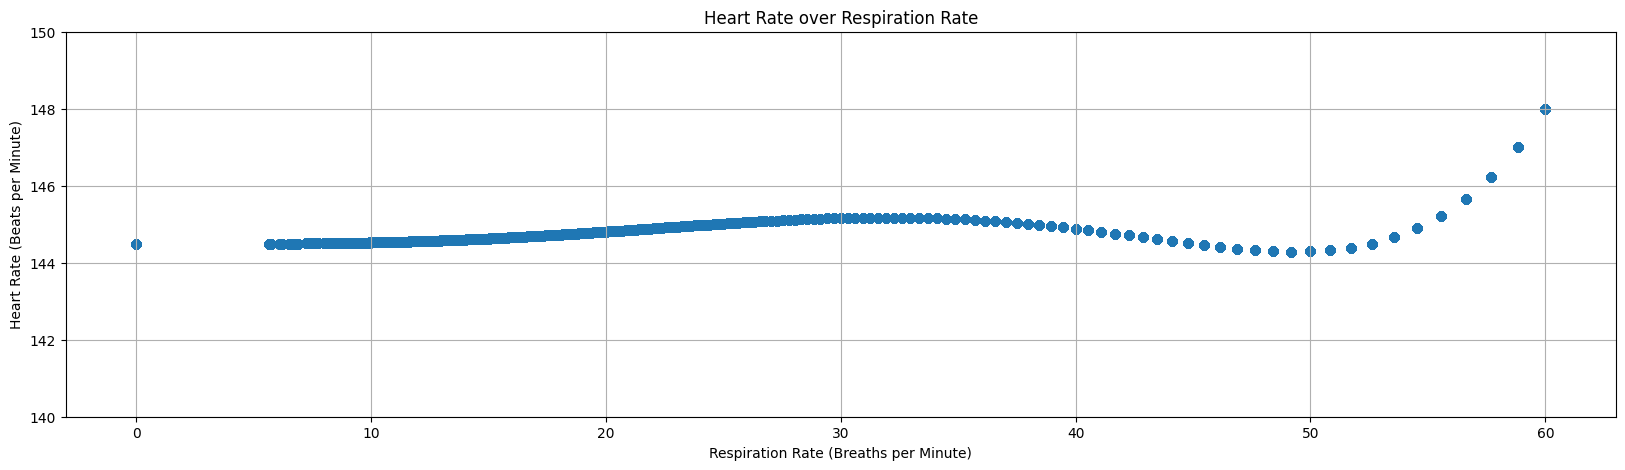

In [20]:
plt.figure(num=1, figsize=(20,5))
plt.scatter(X, y_pr_predict)
plt.ylim(140,150)
plt.grid(True)
plt.xlabel('Respiration Rate (Breaths per Minute)')
plt.ylabel('Heart Rate (Beats per Minute)')
plt.title('Heart Rate over Respiration Rate')

In [21]:
def test_svr_rbf_model(model, X, y, scaler='MinMax', **kwargs):
    X = X.reshape((-1,1))
    y = y.reshape((-1,1))

    # feature scaling
    if scaler == 'MinMax':
        MinMax_X = MinMaxScaler()
        MinMax_y = MinMaxScaler()
        X_l = MinMax_X.fit_transform(X)
        # y_p = MinMax_y.fit_transform(y)
    else: 
        StdS_X = StandardScaler()
        StdS_y = StandardScaler()
        X_l = StdS_X.fit_transform(X)
        # y_p = StdS_y.fit_transform(y)

    y_p_predict = svr_rbf.predict(X_l)

    if scaler == 'MinMax':
        y_predict = MinMax_y.inverse_transform(y_p_predict.reshape(-1,1))
    else:
        y_predict = StdS_y.inverse_transform(y_p_predict.reshape(-1,1))
    
    mae = mean_absolute_error(y, y_predict)
    mse = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    return y_predict

In [22]:
def average_svr_rbf_model_predict(X, y):
    step = 0.25
    startHrs = 10
    endHrs = 12
    degree = 6

    filename = f"../models/infant_1/svr_rbf_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
    print(filename)
    load_svr_rbf_models = joblib.load(filename)
    y_predict = test_svr_rbf_model(model=load_svr_rbf_models, X=X, y=y)

    for infantNum in range(2, 9, 1):
        filename = f"../models/infant_{infantNum}/svr_rbf_model_step{step}_startHrs{startHrs}_endHrs{endHrs}.sav"
        print(filename)
        load_svr_rbf_models = joblib.load(filename)
        y_predict_temp = test_svr_rbf_model(model=load_svr_rbf_models, X=X, y=y)
        y_predict += y_predict_temp

    y_predict = y_predict/8
    print("-------------------------------------------------------------------------------------------")
    mae = mean_absolute_error(y, y_predict)
    mse = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    return y_predict

In [23]:
y_svr_rbf_predict = average_pr_model_predict(X=X,y=y)

../models/infant_1/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 27.57
Mean squared error: 911.64
Root mean squared error: 30.19
../models/infant_2/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.18
Mean squared error: 333.18
Root mean squared error: 18.25
../models/infant_3/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 11.43
Mean squared error: 328.61
Root mean squared error: 18.13
../models/infant_4/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 40.08
Mean squared error: 1867.62
Root mean squared error: 43.22
../models/infant_5/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 32.53
Mean squared error: 1248.74
Root mean squared error: 35.34
../models/infant_6/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 13.18
Mean squared error: 358.42
Root mean squared error: 18.93
../models/infant_7/pr_model_step0.25_startHrs10_endHrs12.sav
Mean absolute error: 33.43
Mean squared error: 1284.19
Root m

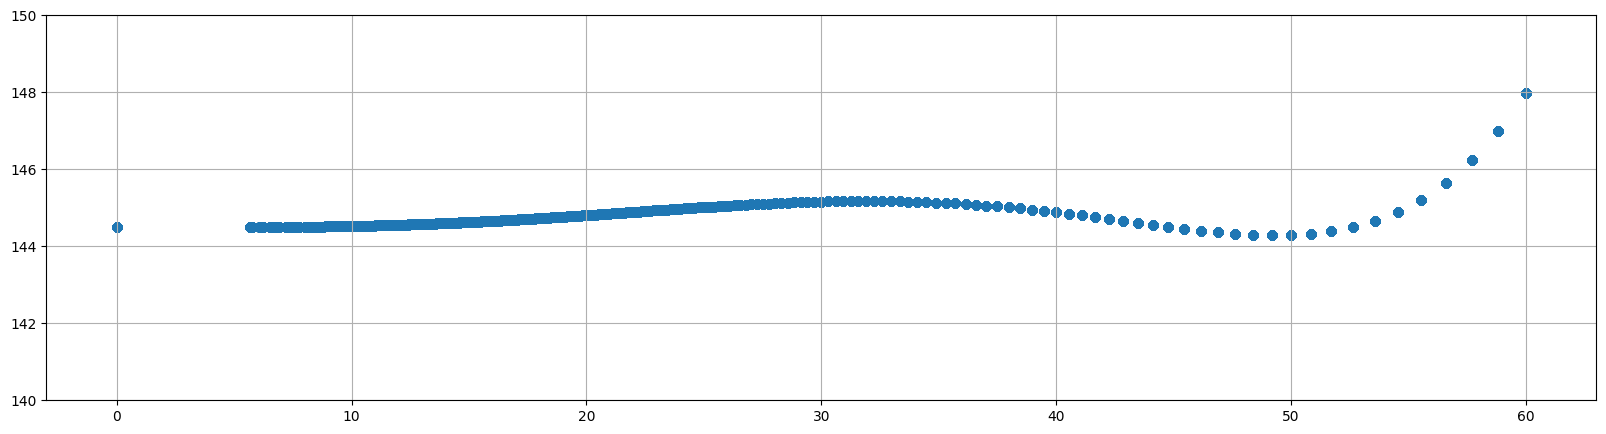

In [27]:
plt.figure(num=1, figsize=(20,5))
plt.scatter(X, y_svr_rbf_predict)
plt.ylim(140,150)
plt.grid(True)